In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from read_data import *
from model_simulations import *
from numpy import linalg as LA
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline
%load_ext autoreload
%aimport read_data
%aimport model_simulations
%autoreload 1

## Simulation


1. Randomly infect people in each state with probability `p_inf`
    - Calculate fraction of infected people
2. Air travel the people
    - Fraction of infected air travelers is the same as origin state
    - Each person has a chance to infect every other person in the new state with probability `p_transfer`
3. In each state, either recover, kill, or remain infected the people there with probability `p_rec, p_die, p_stay`
4. Increment, or decrement, population between years (not quarters)

Totally, there are 4 parameters: `p_inf`, `p_transfer`, `p_rec`, `p_die`

Note `p_stay = 1 - p_rec - p_die`

Can make into a 3 parameter model by setting `p_stay = 0` i.e., between quarters, people either heal completely, or die.

### Goal: Find the best parameters that represent the number of deaths observed

In [3]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)

adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]
for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        network_fname = str(year) + "_Q" + str(quarter) + ".csv"
        A[year][quarter] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
        all_population[year].append(pop)
        if year == 2018:
            all_population[2019].append(pop)
        
A_dict = A

In [4]:
deaths_matrix = {-1: [], 1: [], 2: [], 3: [], 4:[]}
for state, yearly_deaths_dict in deaths_dict.items():
    deaths_vector = {}
    for q in deaths_matrix:
        deaths_vector[q] = []
    for year, quarterly_deaths_dict in yearly_deaths_dict.items():
#         if year > 2012:
#             continue
        for quarter, deaths_count in quarterly_deaths_dict.items():
            deaths_vector[-1].append(deaths_count)
            deaths_vector[quarter].append(deaths_count)
    for q in deaths_matrix:
        deaths_matrix[q].append(deaths_vector[q])
        

for q in deaths_matrix:
    deaths_matrix[q] = np.array(deaths_matrix[q])
    print(deaths_matrix[q].shape)

(50, 38)
(50, 10)
(50, 9)
(50, 9)
(50, 10)


In [16]:
# Fix parameters of the model
P_inf = np.linspace(0.05, 0.2, num=100)
P_transfer = np.linspace(0, 1, num=100)
P_rec = np.linspace(0, 1, num=100)
p_die = 7.540044190323758e-05

sim_quarter = 1
touch_fraction = 1

x0 = np.array([P_inf[23], P_transfer[10], P_rec[33]])
Y_est = run_full_simulation(x0, A_dict, all_population, years,
                            sim_quarter=sim_quarter, touch_fraction=touch_fraction)
cost = get_cost(deaths_matrix[sim_quarter], Y_est)
print(cost)

0.6287975490966751


### Random Walks?

In [87]:
def perturbe(x, mu=0, sigma=1e-4):
    return x + np.random.normal(mu, sigma, size=x.shape)

def isvalid(x):
    return (x <= 1).all() and (x >= 0).all()

error_tol = 1e-4
quarter = 1
touch_fraction = 0.5

x_best = np.array([0.1, 0.1, 0.99])
# x_best = np.random.uniform(0, 1, size=(3,))
print(x_best)
Y_est = run_full_simulation(x_best, A_dict, all_population, years,
                            sim_quarter=quarter, touch_fraction=touch_fraction)
error = get_cost(deaths_matrix[quarter], Y_est)
error_best = error

print("0", error)

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best, mu=0, sigma=1e-2)
#     x_i = x_best + np.random.normal(0, 1e-3, size=x_best.shape)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    Y_est = run_full_simulation(x_i, A_dict, all_population, years,
                                sim_quarter=quarter, touch_fraction=touch_fraction)
    error = get_cost(deaths_matrix[quarter], Y_est)
    ctr += 1
    if error < error_best:
        x_best = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.001249159995721781
2 0.0012123480418399209
4 0.001210438662614968
5 0.0011977825856319532
6 0.001191258397361794
8 0.001162652089184045
9 0.0011533196883892593
Counter:  10
11 0.0011461559005422773
13 0.0011281904008710254
Counter:  20
21 0.0011236555675854176
22 0.001123204648303949
23 0.0011199140476787453
27 0.0011182991998665154
29 0.0011178753185741802
Counter:  30
39 0.001116996250700342
Counter:  40
Counter:  50
56 0.0011146581820391662
Counter:  60
Counter:  70
Counter:  80
Counter:  90
Counter:  100
Counter:  110


KeyboardInterrupt: 

In [102]:
quarter = 1
print(x_best)
sim_deaths = run_full_simulation(x_best, A_dict, all_population, years,
                                 sim_quarter=quarter, touch_fraction=0.8)
error = get_cost(deaths_matrix[quarter], sim_deaths)
print(error)

[0.17278656 0.1854208  0.96283932]
0.001139643396272344


In [103]:
fraction = np.abs(deaths_matrix[quarter] - sim_deaths)# / deaths_matrix[-1]
np.mean(fraction)

662.19

In [104]:
diff = (deaths_matrix[quarter] - sim_deaths).flatten()
print(np.mean(diff))
print(np.std(diff))

94.23
996.0267873405816


In [96]:
stid = 0

for stid in range(50):
    norm_coeff = LA.norm(deaths_matrix[quarter][stid]) * sim_deaths[stid].shape[0]
    print(stid, LA.norm(sim_deaths[stid] - deaths_matrix[quarter][stid]) / norm_coeff)
    
# print(sim_deaths[stid])
# print(deaths_matrix[quarter][stid])

0 1.084679877544705
1 0.08880597384308996
2 0.04475176647042406
3 0.05838898553337512
4 0.015844383063742477
5 0.02408892455032691
6 0.03333905651475477
7 0.01940239762962682
8 0.01144804698545412
9 0.01844855378627392
10 0.02697145045892731
11 0.06367972493648971
12 0.6832499681394693
13 0.05593081970859106
14 0.06529900558011029
15 0.03270893520425713
16 0.041445744163291665
17 0.017687821288459957
18 0.08618709521700334
19 0.014202510745555782
20 0.23227547693774855
21 0.020012548382210782
22 0.013466156455278972
23 0.06470830661648738
24 0.04864709930106144
25 0.022993256304065103
26 0.08624079604444869
27 0.1831176490415509
28 0.05031676844650563
29 0.41163239503277926
30 0.07700727203650387
31 0.6166223435491583
32 0.22693762761610312
33 0.09697670933411427
34 0.027967294144472004
35 0.04159277870145067
36 0.01303135882231573
37 0.028707480337519086
38 0.042020666380865344
39 0.026498685158495273
40 0.038100832171867126
41 0.03500162741334982
42 0.012856748610896033
43 0.02958981

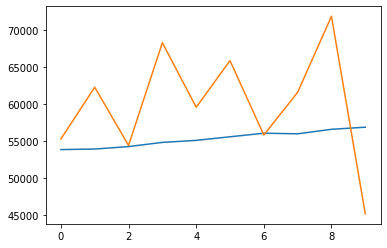

In [105]:
plt.plot(sim_deaths.sum(axis=0))
plt.plot(deaths_matrix[1].sum(axis=0))

In [106]:
sim_deaths.sum(axis=0)

array([53893, 53965, 54299, 54863, 55137, 55622, 56104, 56025, 56633,
       56919])

In [107]:
deaths_matrix[1].sum(axis=0)

array([55328., 62320., 54454., 68337., 59616., 65912., 55858., 61637.,
       71918., 45195.])

In [65]:
A_dict[2009][4]

{4: array([[0.000e+00, 0.000e+00, 9.670e+03, ..., 0.000e+00, 5.000e+01,
         0.000e+00],
        [1.000e+01, 0.000e+00, 1.225e+04, ..., 0.000e+00, 3.000e+01,
         0.000e+00],
        [9.590e+03, 1.175e+04, 0.000e+00, ..., 0.000e+00, 4.018e+04,
         4.000e+01],
        ...,
        [1.000e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+01,
         0.000e+00],
        [1.000e+01, 0.000e+00, 3.756e+04, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 5.000e+01, ..., 0.000e+00, 0.000e+00,
         0.000e+00]])}

need beautiful plots!

Tasks

- Get convergence plots
- Do for each season (quarter)
- Learn parameters from first five years and predict the rest
- Repeat with no travel and compare results
- Why are some states absolutely terrible?

In [ ]:
deceased_df = pd.DataFrame.from_records([[i, j] + num_deceased[i][j] for i in num_deceased for j in num_deceased[i]])
deceased_df.to_csv('deceased_df_real_data_3.csv')

### Real Data No Travel

In [ ]:
sim_time = time()

states = []
year_0 = 2009
for state_id in range(50):
    state = State(all_population[year_0][state_id])
    state.num_infected += np.random.binomial(state.num_total, p_inf)
    states.append(state)
    
# Propagate infection
num_deceased_no_travel = {}

# For each year:
for year in years:
    iter_time = time()
    num_deceased_no_travel[year] = {}
    # For each quarter:
    for quarter in range(1, 5):
        if year == 2009 and quarter != 4:
            continue
        if year == 2019 and quarter != 1:
            continue
        # 1. travel and infect
        # 2. Recover
        # 3. Remove deceased and store it
        # 4. Randomly infect
#         states = travel_and_infect_kernel(A_dict[year][quarter], states, p_transfer)
        states = recover_kernel(states, SIR)
        states, dead_peeps = remove_deceased_kernel(states)
        num_deceased_no_travel[year][quarter] = dead_peeps
        states = random_infection_kernel(states, p_inf)
    
    # Inject population
    try:
        pop_vec = inject_population_kernel(states, all_population[year+1])
    except KeyError:
        # We are at the end of our data
        pass
    
    iter_time = time() - iter_time
    print("Elapsed time for {}: {:.3f} s".format(year, iter_time))

sim_time = time() - sim_time
print("Total elapsed time for simulation: {:.3f} s".format(sim_time))

In [ ]:
deceased_no_travel_df = pd.DataFrame.from_records([[i, j] + num_deceased_no_travel[i][j] for i in num_deceased_no_travel for j in num_deceased_no_travel[i]])
deceased_no_travel_df.to_csv('deceased_df_no_travel_real_data_3.csv')
